<a href="https://colab.research.google.com/github/halaaab/IT_326-Project-Group-1/blob/main/Phase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[1] Problem**

Breast cancer is one of the most common cancers affecting women worldwide. Early and accurate diagnosis is crucial for improving treatment outcomes and patient survival rates.
This project aims to analyze a dataset containing features computed from digitized images of fine-needle aspirates (FNA) of breast masses. By applying classification and clustering techniques, we aim to predict whether a tumor is malignant or benign, and to explore patterns and similarities among cases to gain deeper insights into the characteristics of cancerous and non-cancerous cells.

**[2] Data Mining Task**

In this project, we apply two essential data mining techniques: classification and clustering, to predict and better understand breast cancer diagnosis.
For classification, we train a Decision Tree model using features extracted from digitized images of fine-needle aspirates (FNA) of breast masses. These features — such as mean radius, texture, smoothness, compactness, and symmetry — describe the characteristics of cell nuclei.
The goal is to predict whether a tumor is malignant or benign, making this a binary classification problem. The Decision Tree approach is used to learn interpretable rules that can support medical diagnosis and decision-making.
For clustering, we apply the K-Means algorithm to group samples with similar feature patterns without using the diagnosis label. This unsupervised analysis helps uncover hidden structures in the data, identify potential subgroups of tumors, and provide insights into the underlying relationships among the measured features.
Together, these two techniques offer both predictive power and exploratory understanding, supporting early detection and deeper insight into breast cancer characteristics.

**[3] Data**

Markdown cell:
Dataset: Breast Cancer Wisconsin (Diagnostic) from UCI Machine Learning Repository.
• Total records: 569
• Attributes: 30 numeric features describing nuclei properties (radius, texture, area, smoothness, etc.)
• Target label: diagnosis → (M = malignant = 1, B = benign = 0)
• Non-predictive column: id removed during preprocessing.
The dataset was cleaned and normalized in Phase 2 to prepare it for analysis.

In [5]:
# === Load the dataset ===
import pandas as pd
df = pd.read_csv('Preprocessed_dataset.csv')
df.head()


,id,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,symmetry_se,symmetry_worst
0,842302,1,17.99,10.38,0.11840,0.27760,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.03003,0.4601
1,842517,1,20.57,17.77,0.08474,0.07864,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01389,0.2750
2,84300903,1,19.69,21.25,0.10960,0.15990,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.02250,0.3613
3,84348301,1,11.42,20.38,0.14250,0.28390,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05963,0.6638
4,84358402,1,20.29,14.34,0.10030,0.13280,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.01756,0.2364


**[4] Data Preprocessing**

The preprocessing phase (Phase 2) inclu\ded several key steps:
Removing non-informative attributes such as ID.
Handling correlated features: For each pair of highly correlated variables, one feature was removed to reduce redundancy.
Selecting relevant features: Only one feature selection method was used (SelectKBest with mutual information) to ensure meaningful and interpretable results.
Encoding the target label: Malignant and Benign were mapped to 1 and 0, respectively.
Saving the cleaned dataset as Preprocessed_dataset.csv for use in this phase.
This ensured that the model training and evaluation are based on the most representative and non-redundant attributes.

In [6]:
# Verify structure and label distribution
df.info()
df['diagnosis'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      569 non-null    int64  
 1   diagnosis               569 non-null    int64  
 2   radius_mean             569 non-null    float64
 3   texture_mean            569 non-null    float64
 4   smoothness_mean         569 non-null    float64
 5   compactness_mean        569 non-null    float64
 6   symmetry_mean           569 non-null    float64
 7   fractal_dimension_mean  569 non-null    float64
 8   radius_se               569 non-null    float64
 9   texture_se              569 non-null    float64
 10  smoothness_se           569 non-null    float64
 11  compactness_se          569 non-null    float64
 12  symmetry_se             569 non-null    float64
 13  symmetry_worst          569 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 62.

,count
diagnosis,
0,357
1,212


**[5] Data Mining Technique**
- Classification – Decision Tree
Markdown cell:
We train Decision Tree models under three train/test splits ( 90/10, 80/20, 70/30 ) using two criteria (Gini and Entropy).
The accuracy and confusion matrix for each run are reported.
The best performing tree is visualized to interpret feature importance and decision paths.

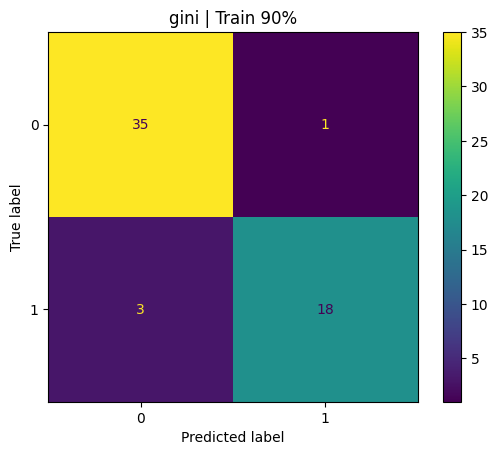

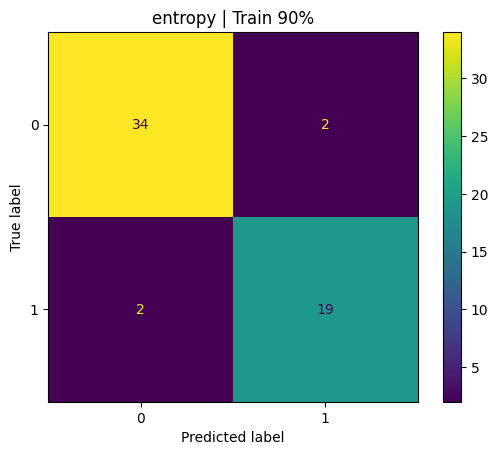

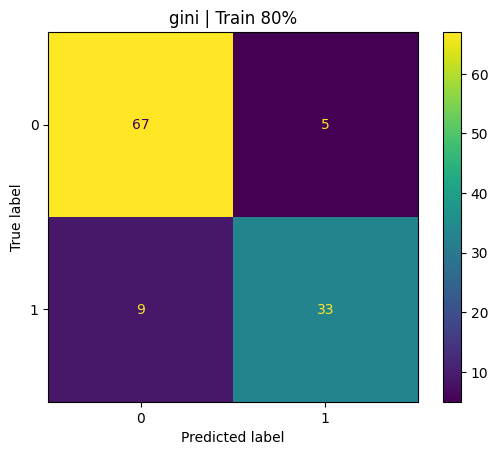

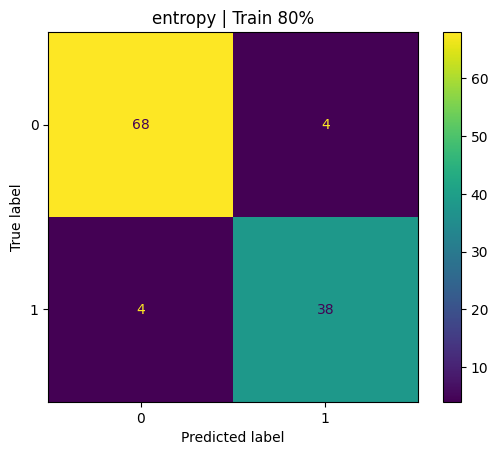

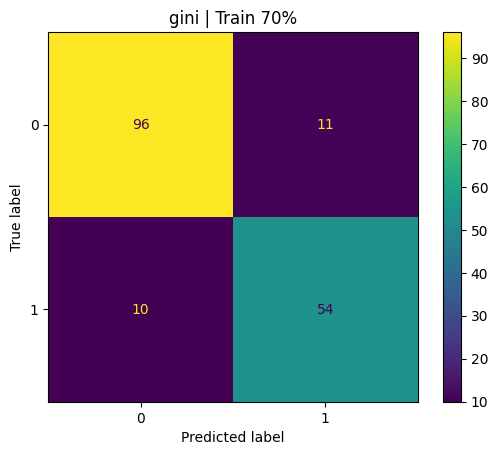

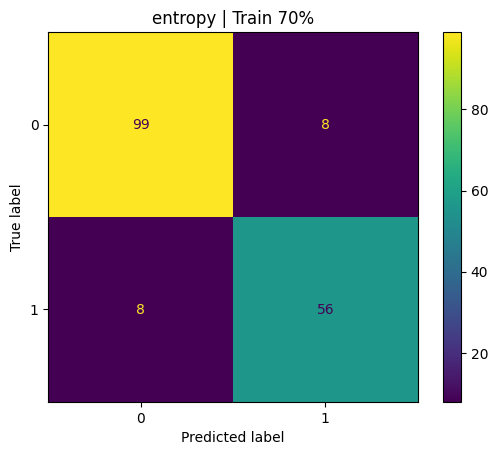

,Train%,Criterion,Accuracy
0,90,gini,0.929825
1,90,entropy,0.929825
2,80,gini,0.877193
3,80,entropy,0.929825
4,70,gini,0.877193
5,70,entropy,0.906433


In [7]:
# === Decision Tree Classification ===
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

splits = [(0.9,0.1),(0.8,0.2),(0.7,0.3)]
criteria = ['gini','entropy']
results = []

for tr,te in splits:
    Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=te,random_state=42,stratify=y)
    for c in criteria:
        clf = DecisionTreeClassifier(criterion=c,random_state=42)
        clf.fit(Xtr,ytr)
        yp = clf.predict(Xte)
        acc = accuracy_score(yte,yp)
        cm  = confusion_matrix(yte,yp)
        results.append({'Train%':int(tr*100),'Criterion':c,'Accuracy':acc})
        ConfusionMatrixDisplay(cm).plot()
        plt.title(f'{c} | Train {int(tr*100)}%')
        plt.show()

pd.DataFrame(results)


{'Train%': 90, 'Criterion': 'gini', 'Accuracy': 0.9298245614035088}


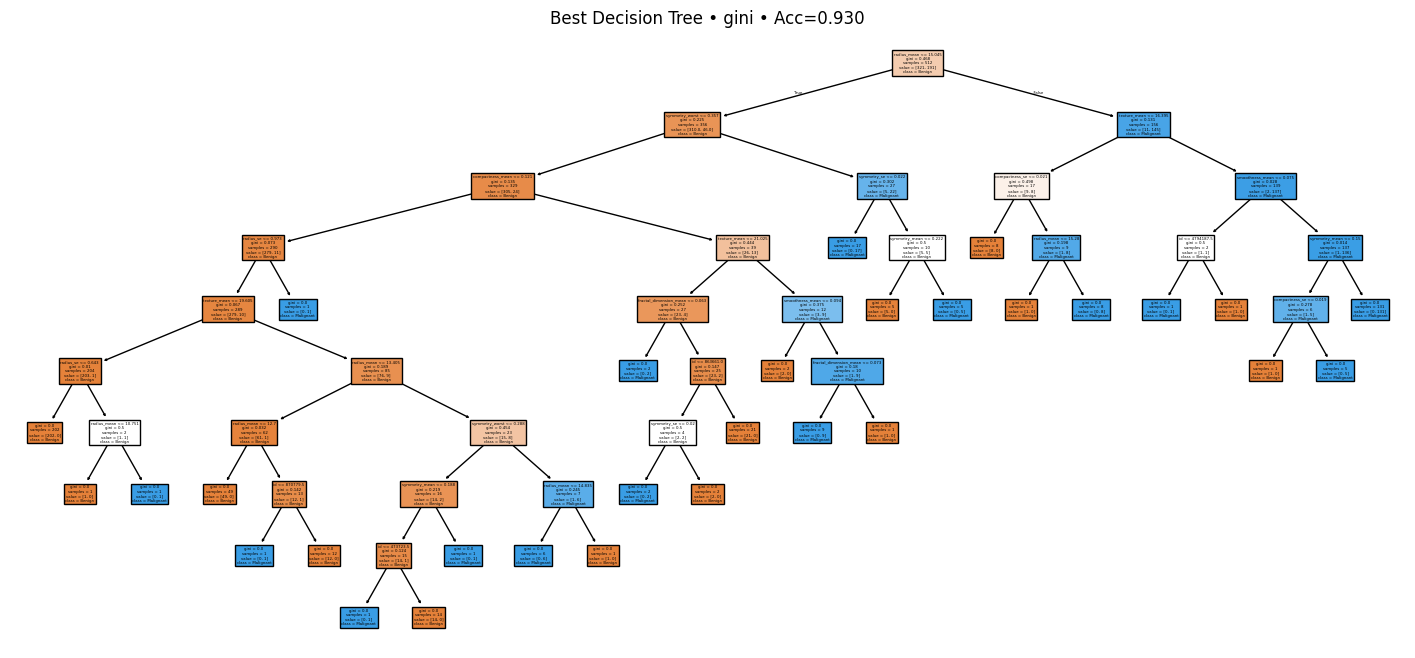

In [8]:
# Plot best-performing tree
best = max(results, key=lambda x:x['Accuracy'])
print(best)
clf_best = DecisionTreeClassifier(criterion=best['Criterion'],random_state=42)
Xtr,Xte,ytr,yte = train_test_split(X,y,test_size=(100-best['Train%'])/100,random_state=42,stratify=y)
clf_best.fit(Xtr,ytr)
plt.figure(figsize=(18,8))
plot_tree(clf_best,filled=True,feature_names=X.columns,class_names=['Benign','Malignant'])
plt.title(f"Best Decision Tree • {best['Criterion']} • Acc={best['Accuracy']:.3f}")
plt.show()


**Clustering – K-Means**

Markdown cell:
K-Means is applied to the feature set (without labels) for K = 2 to 5.
We evaluate each K using Average Silhouette and Within-Cluster Sum of Squares (Inertia).
Elbow and Silhouette plots determine the optimal number of clusters.
PCA (2-components) is used for visualization.

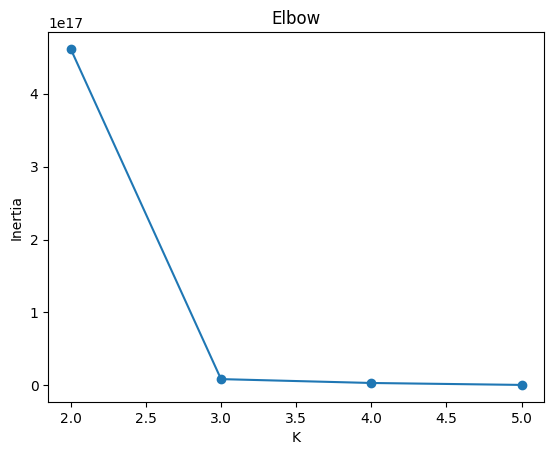

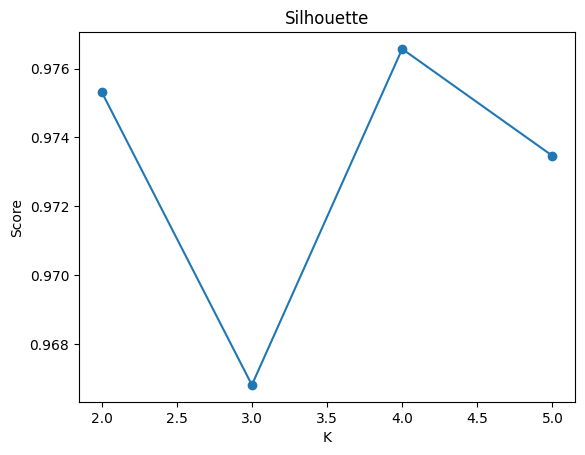

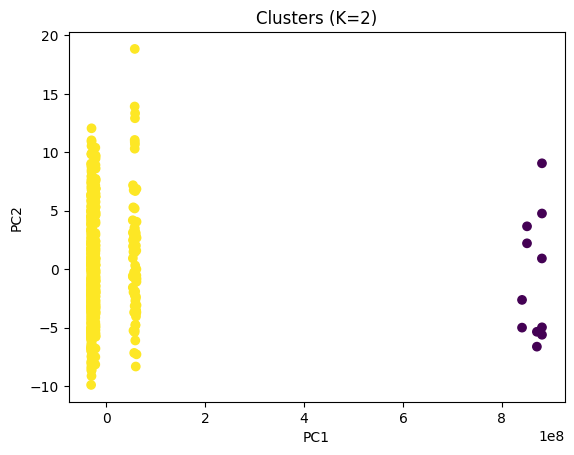

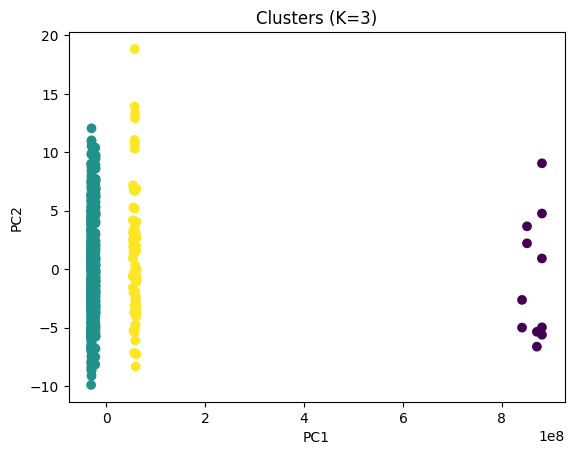

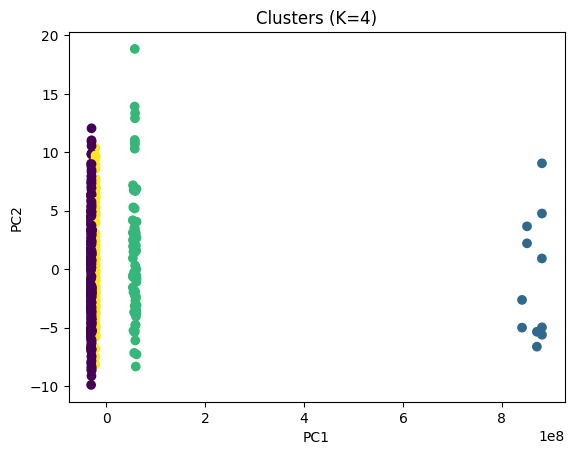

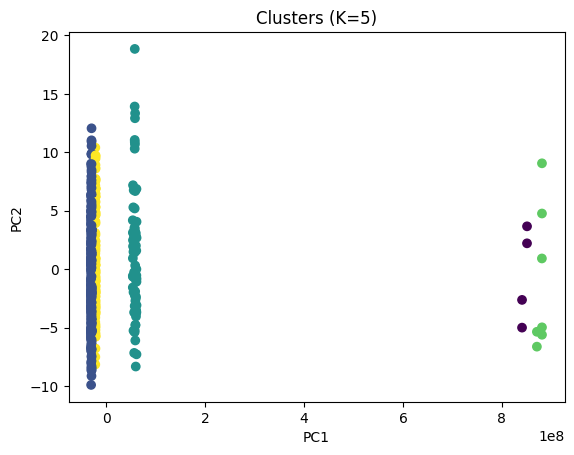

,K,Average Silhouette,Within-SS (Inertia)
0,2,0.975328,4.613428e+17
1,3,0.966819,8.618045e+15
2,4,0.976571,3.314088e+15
3,5,0.973467,6.559315e+14


In [9]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

Ks=[2,3,4,5]
sil,inert=[],[]
for k in Ks:
    km=KMeans(n_clusters=k,n_init=10,random_state=42)
    labels=km.fit_predict(X)
    sil.append(silhouette_score(X,labels))
    inert.append(km.inertia_)

plt.plot(Ks,inert,marker='o'); plt.title('Elbow'); plt.xlabel('K'); plt.ylabel('Inertia'); plt.show()
plt.plot(Ks,sil,marker='o'); plt.title('Silhouette'); plt.xlabel('K'); plt.ylabel('Score'); plt.show()

pca=PCA(n_components=2,random_state=42)
X2=pca.fit_transform(X)
for k in Ks:
    km=KMeans(n_clusters=k,n_init=10,random_state=42)
    lab=km.fit_predict(X)
    plt.scatter(X2[:,0],X2[:,1],c=lab)
    plt.title(f'Clusters (K={k})'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

pd.DataFrame({'K':Ks,'Average Silhouette':sil,'Within-SS (Inertia)':inert})
